In [2]:
import pandas as pd
import pandas as pd
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt

In [3]:
# Read the Parquet file
cell_table_all_merged_thresholded = pd.read_parquet("/Users/piyadasa/Library/CloudStorage/GoogleDrive-piyadasa@stanford.edu/My Drive/Projects/GBM/Cohort_analysis/tables/cell_table_all_merged_thresholded.parquet")

# Read the CSV file
metadata = pd.read_csv('/Users/piyadasa/Library/CloudStorage/GoogleDrive-piyadasa@stanford.edu/Shared drives/BRUCE_data/metadata/metadata_complete.csv')

In [4]:
# Merge the two dataframes on the 'sample_id' column, keeping all duplicates
cell_table_all_merged_thresholded = pd.merge(cell_table_all_merged_thresholded, metadata, on='sample_id', how='outer', indicator=True)

# Display the first few rows of the merged dataframe to confirm the merge
print(cell_table_all_merged_thresholded.head())

              fov        V1  Unnamed: 0.12  cell_size     ApoE          Au  \
0             NaN       NaN            NaN        NaN      NaN         NaN   
1  CHOP_1101_R4C1  173937.0       173937.0      174.0  100.199  782.938937   
2  CHOP_1101_R4C1  173938.0       173938.0      727.0  100.199  719.722748   
3  CHOP_1101_R4C1  173939.0       173939.0      585.0  100.199  325.998905   
4  CHOP_1101_R4C1  173940.0       173940.0      199.0  100.199  438.159901   

         B7H3     CD133      CD14     CD163  ...  had_chemotherapy  \
0         NaN       NaN       NaN       NaN  ...           unknown   
1    0.014402  0.010800  0.003268  0.011871  ...           unknown   
2    0.004208  0.010384  0.005184  0.024989  ...           unknown   
3    0.002415  0.004330  0.003277  0.011556  ...           unknown   
4  100.199000  0.002289  0.001000  0.004816  ...           unknown   

   had_radiation  treatment_prior_to_surgery  combined_label  \
0        unknown                     unknown  

In [15]:
# Function to filter data and create Venn diagrams for each diagnosis
def process_and_create_venn(data, func_col1, func_col2):
    
    # Step 1: Filter the data based on the specified criteria
    filtered_data = data[
        (data['cell_meta_cluster_final'] == 'Tumor_cells') &
        (data['source'] == 'cell_table_tumor') &
        (data['final_diagnosis_simple'].isin(['GBM', 'Astrocytoma', 'Oligodendroglioma']))
    ]
    
    # Step 2: Get the list of unique diagnoses
    diagnoses = filtered_data['final_diagnosis_simple'].unique()
    
    # Create an empty DataFrame to store the counts for each diagnosis
    count_df = pd.DataFrame(columns=['Diagnosis', 'Only_func1', 'Only_func2', 'Both_expressed'])
    
    # Step 3: Loop through each diagnosis to calculate counts and store them
    for diagnosis in diagnoses:
        
        # Subset data for the current diagnosis
        diagnosis_data = filtered_data[filtered_data['final_diagnosis_simple'] == diagnosis]
        
        # Remove rows with NA in the specified func columns
        diagnosis_data = diagnosis_data.dropna(subset=[func_col1, func_col2])
        
        # Calculate counts
        only_func1 = ((diagnosis_data[func_col1] == 1) & (diagnosis_data[func_col2] == 0)).sum()
        only_func2 = ((diagnosis_data[func_col1] == 0) & (diagnosis_data[func_col2] == 1)).sum()
        both_expressed = ((diagnosis_data[func_col1] == 1) & (diagnosis_data[func_col2] == 1)).sum()
        
        # Print counts for debugging
        print(f"Diagnosis: {diagnosis}")
        print(f"Only {func_col1}: {only_func1}")
        print(f"Only {func_col2}: {only_func2}")
        print(f"Both Expressed: {both_expressed}\n")
        
        # Calculate total number of Tumor_cells for the diagnosis
        total_tumor_cells = len(diagnosis_data)
        
        # Calculate percentages
        only_func1_percent = ((diagnosis_data[func_col1] == 1) & (diagnosis_data[func_col2] == 0)).sum() / total_tumor_cells * 100
        only_func2_percent = ((diagnosis_data[func_col1] == 0) & (diagnosis_data[func_col2] == 1)).sum() / total_tumor_cells * 100
        both_expressed_percent = ((diagnosis_data[func_col1] == 1) & (diagnosis_data[func_col2] == 1)).sum() / total_tumor_cells * 100
        
        # Print percentages for debugging
        print(f"Diagnosis: {diagnosis}")
        print(f"Only {func_col1} (%): {only_func1_percent:.2f}")
        print(f"Only {func_col2} (%): {only_func2_percent:.2f}")
        print(f"Both Expressed (%): {both_expressed_percent:.2f}\n")
        
        
        # Create a DataFrame row for the current diagnosis
        new_row = pd.DataFrame({
            'Diagnosis': [diagnosis],
            'Only_func1': [only_func1],
            'Only_func2': [only_func2],
            'Both_expressed': [both_expressed]
        })
        
        # Append the new row to the count_df using pd.concat()
        count_df = pd.concat([count_df, new_row], ignore_index=True)
    
    return count_df

# Function to create Venn diagrams for each diagnosis and save them as SVG files
def create_venn_for_each_diagnosis(count_df):
    for index, row in count_df.iterrows():
        # Extract counts for the diagnosis
        only_func1 = row['Only_func1']
        only_func2 = row['Only_func2']
        both_expressed = row['Both_expressed']
        diagnosis = row['Diagnosis']
        
        # Step 4: Depict the Venn diagram for each diagnosis
        plt.figure(figsize=(6, 6))
        venn2(subsets=(only_func1, only_func2, both_expressed), 
              set_labels=(func_col1, func_col2),
              set_colors=("orange", "blue"), alpha=1)
        
        # Add outlines
        venn2_circles(subsets=(only_func1, only_func2, both_expressed), color='black', linewidth=0.2)
        
        # Add a title to the Venn diagram
        plt.title(f"Venn Diagram for {diagnosis}")
        
        # # Save the plot as an SVG file
        # plt.savefig(f"Venn_{diagnosis}_{func_col1}_{func_col2}.svg", format='svg', transparent=False)
        
        # Show the plot (optional)
        plt.show()



Diagnosis: GBM
Only B7H3_func: 53326
Only EGFR_func: 10380
Both Expressed: 39071

Diagnosis: GBM
Only B7H3_func (%): 44.61
Only EGFR_func (%): 8.68
Both Expressed (%): 32.69

Diagnosis: Oligodendroglioma
Only B7H3_func: 23681
Only EGFR_func: 28773
Both Expressed: 55021

Diagnosis: Oligodendroglioma
Only B7H3_func (%): 10.42
Only EGFR_func (%): 12.66
Both Expressed (%): 24.22

Diagnosis: Astrocytoma
Only B7H3_func: 39694
Only EGFR_func: 23865
Both Expressed: 45704

Diagnosis: Astrocytoma
Only B7H3_func (%): 19.51
Only EGFR_func (%): 11.73
Both Expressed (%): 22.46



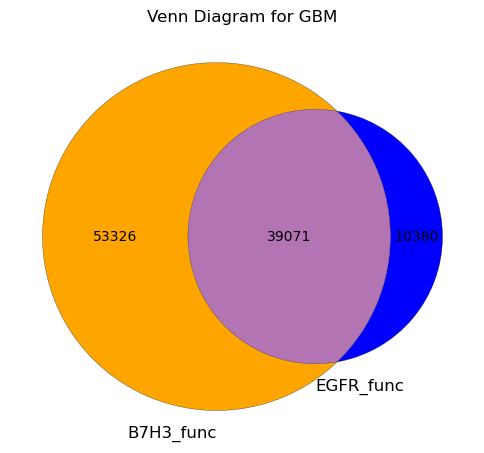

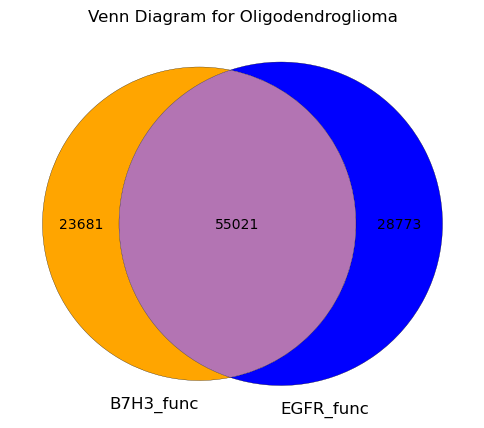

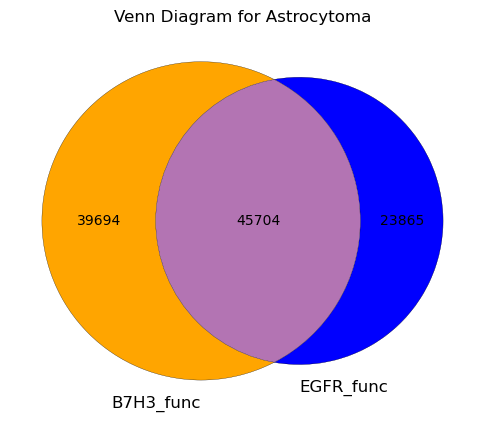

In [16]:
# Example usage
# Assuming `cell_table_all_merged_thresholded` is a pandas DataFrame
func_col1 = "B7H3_func"  # Replace with the actual column name
func_col2 = "EGFR_func"  # Replace with the actual column name

# Process the data and create Venn diagrams
count_df = process_and_create_venn(cell_table_all_merged_thresholded, func_col1, func_col2)
create_venn_for_each_diagnosis(count_df)

Diagnosis: GBM
Only B7H3_func: 67006
Only HER2_func: 3706
Both Expressed: 25391

Diagnosis: GBM
Only B7H3_func (%): 56.06
Only HER2_func (%): 3.10
Both Expressed (%): 21.24

Diagnosis: Oligodendroglioma
Only B7H3_func: 60841
Only HER2_func: 11640
Both Expressed: 17861

Diagnosis: Oligodendroglioma
Only B7H3_func (%): 26.78
Only HER2_func (%): 5.12
Both Expressed (%): 7.86

Diagnosis: Astrocytoma
Only B7H3_func: 59122
Only HER2_func: 15979
Both Expressed: 26276

Diagnosis: Astrocytoma
Only B7H3_func (%): 29.05
Only HER2_func (%): 7.85
Both Expressed (%): 12.91



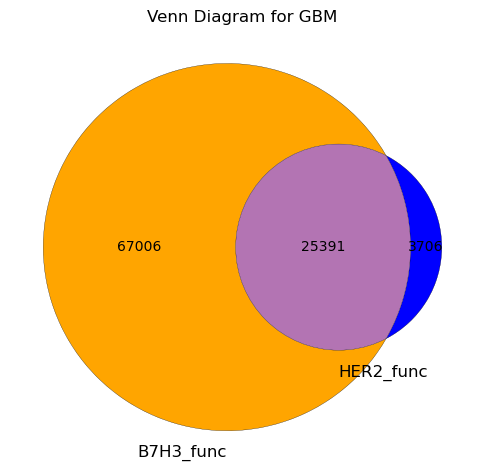

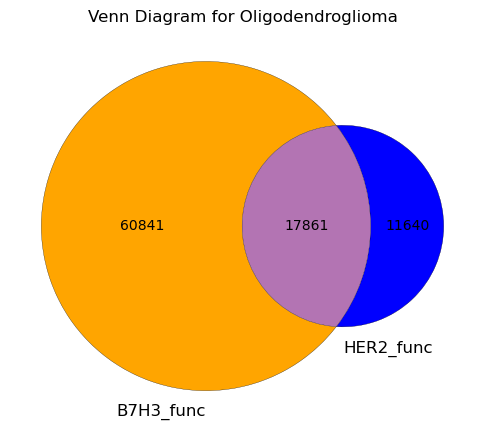

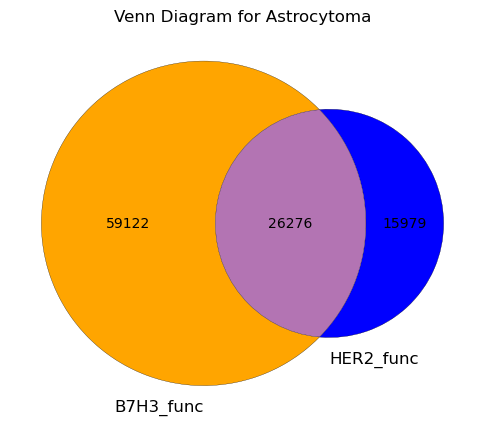

In [17]:
# Example usage
# Assuming `cell_table_all_merged_thresholded` is a pandas DataFrame
func_col1 = "B7H3_func"  # Replace with the actual column name
func_col2 = "HER2_func"  # Replace with the actual column name

# Process the data and create Venn diagrams
count_df = process_and_create_venn(cell_table_all_merged_thresholded, func_col1, func_col2)
create_venn_for_each_diagnosis(count_df)